## Keyword analysis per category

RAKE?
Benjamini–Hochberg FDR?

In [1]:
import utils.preprocessing as prep
import pandas as pd
from functools import partial
df, label_cols = prep.load_dataset("data/dataset.pkl")
display(df["genre"].unique())
print(label_cols)

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array(['direct', 'social', 'news'], dtype=object)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')


In [2]:
df["clean_text"] = df["message"].apply(partial(prep.text_preprocessor, lemmatize =True, remove_stopwords = False, join = True))
display(df["clean_text"].head(5))
df = df[df["related"] == 1]

0    weather update a cold front from cuba that cou...
1              is the hurricane over or is it not over
2                      looking for someone but no name
3    un report leogane destroyed only hospital st c...
4    say west side of haiti rest of the country tod...
Name: clean_text, dtype: object

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import numpy as np

In [4]:
vectorizer = CountVectorizer(binary = True, min_df=5)
bow_matrix = vectorizer.fit_transform(df["clean_text"])
vocabulary = vectorizer.get_feature_names_out()

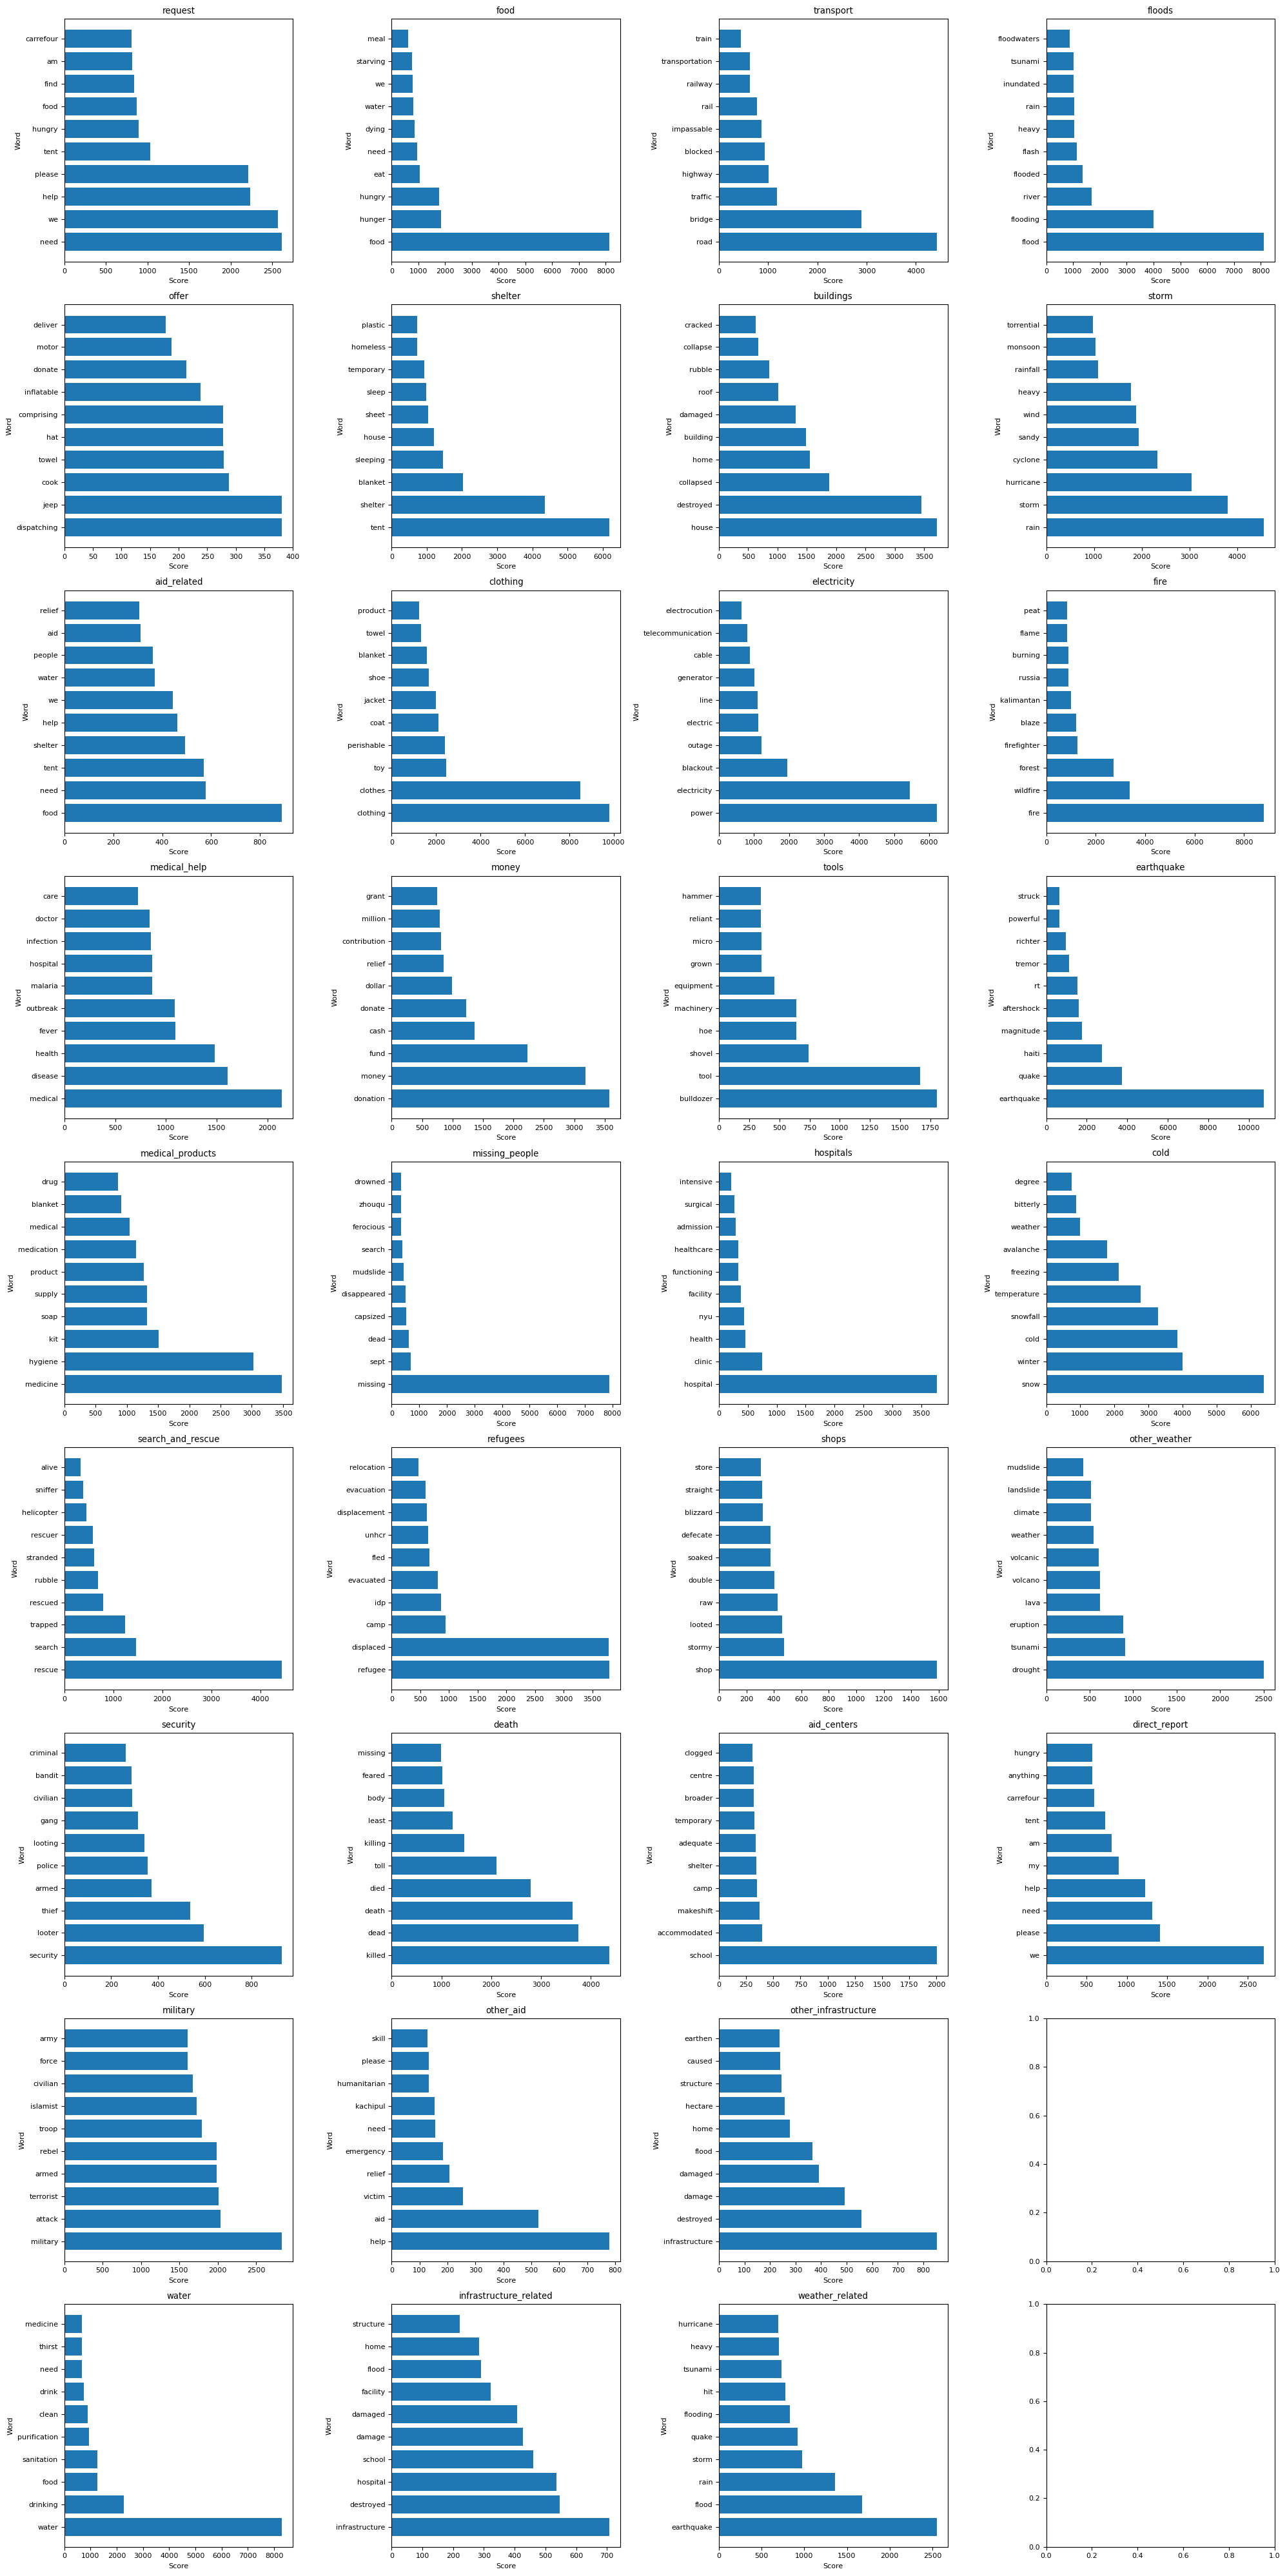

In [5]:
import matplotlib.pyplot as plt
def keywords(bow_mat, labels, score_percentile, show_top = 10, idf_reweight = True):
    word_scores = {}
    plt.rcParams["font.size"] = 8
    fig, ax = plt.subplots(9, 4)
    fig.set_size_inches(20, 40)
    r, c = 0, 0
    if idf_reweight:
        doc_freq = bow_mat.sum(axis = 0)
        N = bow_mat.shape[0]
        idf = np.log10((N+1) / (doc_freq + 1)).A1

    for label in labels:
        (chi_scores, p_values) = chi2(bow_mat, df[label])
        filt1 = p_values < 0.05
        lower_bound = np.percentile(chi_scores[filt1], score_percentile)
        inds = np.argwhere((chi_scores >= lower_bound) & filt1)
        current_vocab = vocabulary[inds].ravel()
        current_scores = chi_scores[inds]
        if idf_reweight:
            current_scores = current_scores * idf[inds]
        current_scores = current_scores.ravel()
        
        word_scores[label] = tuple((current_vocab, current_scores))
        inds = np.argsort(current_scores)[::-1]
        ax[r, c].barh(current_vocab[inds][:show_top], width=current_scores[inds][:show_top])
        ax[r, c].set_title(label)
        ax[r, c].set_xlabel("Score")
        ax[r, c].set_ylabel("Word")
        r += 1
        if r == 9:
            r = 0
            c += 1
    plt.tight_layout()
    plt.show()
    return word_scores
keywords_scores = keywords(bow_matrix, label_cols[1:], 80, 10)

In [6]:
from nltk import FreqDist
FreqDist(df["clean_text"].to_list())


FreqDist({'': 8, 'information about the earthquake': 5, 'note this message is not complete': 3, 'coming to don t want to spend than u day looking a trendy then visit hostal de la barra': 3, 'in my village after collapse of whole infrastructure due to flood the majority of people is homeless in need of tent which are not available': 3, 'port au prince and food they need goverment aid and international aid thak you god bless haiti': 2, 'we need food and water please': 2, 'i would like to know when the aftershock will end': 2, 'please we need water food and tent we have chlidren please come rescue': 2, 'we need help at delmas across from kiskeya christian school tank u': 2, ...})